# Separate the original pdb file into two pdb files, one for the protein and one for the small molecule.
`1. protein.pdb`  
`2. ligand_raw.pdb`


# Convert ligand_raw.pdb to mol2 format

Open the ligand_raw.pdb file in UCSF chimera. Choose Tools > Structure Editing > addH. Save as .mol2 file
`ligand.mol2`

For alternative methods to get a .mol2 file for your ligand, see the useful links section in the SwissParam webpage


# Generate ligand topology with Swissparam

Go to SwissParam and submit the ligand.mol2 file. You will get the output in the results page. Uncompress the archive:  
`> tar -xf results.tar.gz`

For this tutorial using GROMACS, you will only need the pdb file (with hydrogens) and the .itp file with the GROMACS topology of the ligand:  
`ligand.pdb`  
`ligand.itp`


# Mount Google Drive and change directory to the location of your MD simulation files


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/MD_Simulation_Results/aloeresin_a_dsba_complex")

In [3]:
!pwd

/content/drive/MyDrive/MD_Simulation_Results/aloeresin_a_dsba_complex


# Install Gromacs

In [4]:
! apt-get update && apt-get install -y gromacs

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,294 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,535 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,520 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/

In [5]:
!gmx --version

                 :-) GROMACS - gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

# Generate a GROMACS topology for the protein without the ligand


In [6]:
# !gmx pdb2gmx -f protein.pdb -ff charmm27 -water tip3p -ignh -o complex.pdb -nochargegrp

# Build the Topology

Modify the topol.top file generated by pdb2gmx. In the "Include chain topologies" section, add the following statement, before all other lines referring to the protein or ions:

`> #include "ligand.itp"`

This statement has to be at this precise position in the file because it contains [atomtypes] and [pairtypes] sections which have to appear in the topology before any [moleculetype] section. Then, in the [molecules] section, right after lines indicating the number of protein and ion molecules, add the following line:

`> ligand 1`

If there are crystal water molecules in the structure, there will be a line indicating the number of solvent molecules (SOL) in the topology.

# Build the complex

Merge the protein and ligand coordinates. Insert the ATOM lines from the ligand.pdb into the complex.pdb file. Atoms will be automatically renumbered in the next step.

Note: Paste it into complex.pdb, below the last line of the protein atoms, and before the box vectors.

# Add solvent and ions to the complex

Define a box and solvate the system. Also add ions (using the `ions.mdp script`) to neutralize the system


In [7]:
# !gmx editconf -f complex.pdb -o boxed.gro -c -d 1.2 -bt octahedron

In [8]:
# !gmx solvate -cs -cp boxed.gro -o solvated.gro -p topol.top

In [9]:
# !gmx grompp -f ions.mdp -c solvated.gro -p topol.top -o ions.tpr

In [10]:
# !gmx genion -s ions.tpr -o solvated_ions.gro -p topol.top -pname NA -nname CL -neutral

# Energy minimize the system using the `em.mdp script`

In [11]:
# !gmx grompp -v -f em.mdp -c solvated_ions.gro -p topol.top -o em.tpr

In [12]:
# !gmx mdrun -v -deffnm em

Let's do a bit of analysis. The em.edr file contains all of the energy terms that GROMACS collects during EM. You can analyze any .edr file using the GROMACS energy module. At the prompt, type "12 0" to select Potential (12); zero (0) terminates input.

In [13]:
# !gmx energy -f em.edr -o potential.xvg

In [14]:
import numpy as np
import matplotlib.pyplot as plt

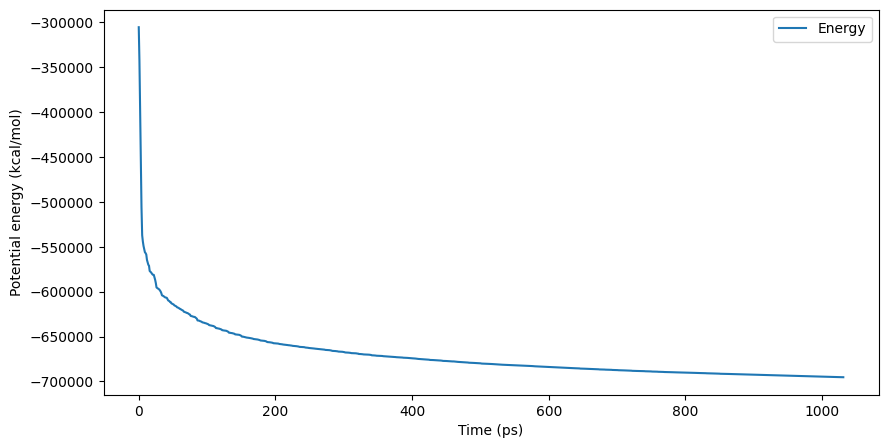

In [15]:
# Load data from the xvg file
data = np.loadtxt('potential.xvg', comments=['#', '@'])

# Extract columns (adjust column indices as needed)
time = data[:, 0]
energy = data[:, 1]

# Plot the data
fig = plt.figure(figsize=(10,5))
plt.plot(time, energy, label='Energy')
plt.xlabel('Time (ps)')
plt.ylabel('Potential energy (kcal/mol)')
plt.legend()
plt.show()

# Perform equilibration
Equilibration is often conducted in two phases. The first phase is conducted under an NVT ensemble (constant Number of particles, Volume, and Temperature). This ensemble is also referred to as "isothermal-isochoric" or "canonical." The timeframe for such a procedure is dependent upon the contents of the system, but in NVT, the temperature of the system should reach a plateau at the desired value. If the temperature has not yet stabilized, additional time will be required. Typically, 50-100 ps should suffice, and we will conduct a 100-ps NVT equilibration for this exercise. Depending on your machine, this may take a while (just under an hour if run in parallel on 16 cores or so).

NVT equilibration, stabilized the temperature of the system. Prior to data collection, we must also stabilize the pressure (and thus also the density) of the system. Equilibration of pressure is conducted under an NPT ensemble, wherein the Number of particles, Pressure, and Temperature are all constant. The ensemble is also called the "isothermal-isobaric" ensemble, and most closely resembles experimental conditions.

Because equilibrating our protein-ligand complex will be much like equilibrating any other system containing a protein in water. There are a few special considerations, in this case:  

`1. Applying restraints to the ligand`  
`2. Treatment of temperature coupling groups.`  

Once these are done, we then proceed to NVT and NPT, respectively.

**Generate the ligand.gro file for the ligand restrainment**

Note: The `ligand.pdb file` will also work fine for generating the index file

In [16]:
# !gmx editconf -f ligand.pdb -o ligand.gro

**To restrain the ligand, we will need to generate a position restraint topology for it. First, create an index group for LIG that contains only its non-hydrogen atoms**

**Run the restrainment and select the following options when prompted:**

> 0 & ! a H*  
> q

In [17]:
# !gmx make_ndx -f ligand.gro -o index_ligand.ndx

**Then, execute the genrestr module and select this newly created index group (which will be group 3 in the `index_ligand.ndx file`):**

In [18]:
# !gmx genrestr -f ligand.gro -n index_ligand.ndx -o posre_ligand.itp -fc 1000 1000 1000

**Now, we need to include this information in our topology. We can do this in several ways, depending upon the conditions we wish to use. If we simply want to restrain the ligand whenever the protein is also restrained, add the following lines to your topology in the location indicated:**

`; Include Position restraint file`  
`#ifdef POSRES`  
`#include "posre.itp"`    
`#endif`  

- `; Include ligand topology`  
- `#include "jz4.itp"`

`; Ligand position restraints`  
`#ifdef POSRES`    
`#include "posre_jz4.itp"`    
`#endif`

`; Include water topology`  
`#include "./charmm36-jul2022.ff/tip3p.itp"`    

Location matters! You must put the call for posre_ligand.itp in the topology as indicated. The parameters within jz4.itp define a [ moleculetype ] directive for our ligand. The moleculetype ends with the inclusion of the water topology (tip3p.itp). Placing the call to posre_ligand.itp anywhere else will attempt to apply the position restraint parameters to the wrong moleculetype.

If you want a bit more control during equilibration, i.e. restraining the protein and ligand independently, you could instead control the inclusion of the ligand position restraint file in a different `#ifdef block`, like so:

`; Include Position restraint file`  
`#ifdef POSRES`    
`#include "posre.itp"`  
`#endif`  

`; Include ligand topology`  
`#include "jz4.itp"`  

- `; Ligand position restraints`  
- `#ifdef POSRES_LIG`
- `#include "posre_jz4.itp"`    
- `#endif`  

`; Include water topology`    
`#include "./charmm36-jul2022.ff/tip3p.itp"`

In the latter case, to restrain both the protein and the ligand, we would need to specify define = -DPOSRES -DPOSRES_LIG in the .mdp file. How you want to treat your system is up to you. These examples are meant only to illustrate the flexibility GROMACS provides. For a standard equilibration procedure, restraining the protein and ligand simultaneously is probably sufficient. Your own needs may vary.

**Thermostats**  
Proper control of temperature coupling is a sensitive issue. Coupling every moleculetype to its own thermostatting group is a bad idea. For instance, if you do the following:

`tc-grps = Protein JZ4 SOL CL`

Your system will probably blow up, since the temperature coupling algorithms are not stable enough to control the fluctuations in kinetic energy that groups with a few atoms (i.e., LIG and NA) will produce. Do not couple every single species in your system separately.

The typical approach is to set tc-grps = Protein Non-Protein and carry on. Unfortunately, the "Non-Protein" group also encompasses LIG. Since LIG and the protein are physically linked very tightly, it is best to consider them as a single entity. That is, LIG is grouped with the protein for the purposes of temperature coupling. In the same way, the few Na+ ions we inserted are considered part of the solvent. To do this, we need a special index group that merges the protein and LIG. We accomplish this with the `make_ndx module`, supplying any coordinate file of the complete system. Here, I am using em.gro, the output (minimized) structure of our system

Run the command and input the following when prompted:

`> 1 | 13`  
`> q`

In [19]:
# !gmx make_ndx -f em.gro -o index.ndx

**Now, run the NVT equilibration using the `nvt.mdp script`**

In [20]:
# !gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -n index.ndx -o nvt.tpr
# !gmx mdrun -v -deffnm nvt

Let's analyze the temperature progression, again using energy:

In [21]:
# !gmx energy -f nvt.edr -o temperature.xvg

Type "17 0" at the prompt to select the temperature of the system and exit. The resulting plot should look something like the following:

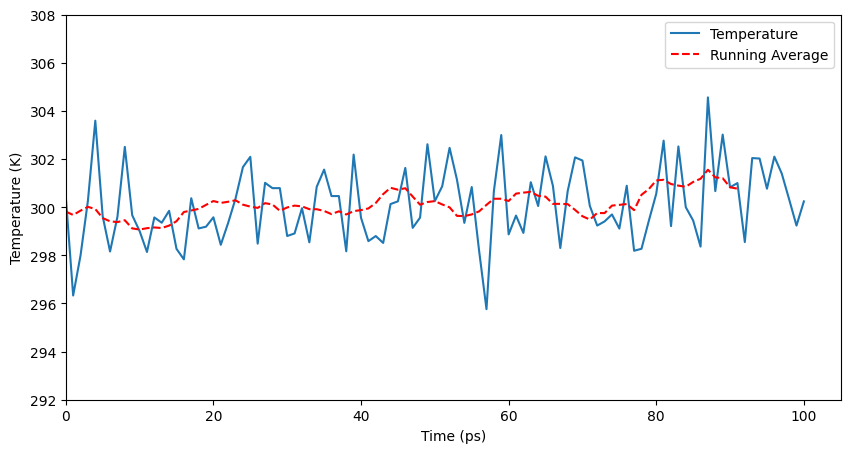

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from the xvg file
data = np.loadtxt('temperature.xvg', comments=['#', '@'])

# Extract columns (adjust column indices as needed)
time = data[:, 0]
temperature = data[:, 1]

# Calculate running average (adjust window size as needed)
window_size = 10
running_average = np.convolve(temperature, np.ones(window_size)/window_size,
                              mode='valid')

# Plot the data and running average
fig = plt.figure(figsize=(10,5))
plt.plot(time, temperature, label='Temperature')
plt.plot(time[:len(running_average)], running_average,
         label=f'Running Average', linestyle='--', color='red')
plt.yticks(np.arange(292.0, 310, step=2))
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.legend()

# Set x-axis and y-axis limits to start from 0
plt.xlim(left=0)
# plt.ylim(bottom=-350)

plt.show()

**After the NVT equilibration, run the NPT equilibration using the `npt.mdp script`**

In [23]:
# !gmx grompp -f npt.mdp -c nvt.gro -t nvt.cpt -r nvt.gro -p topol.top -n index.ndx -o npt.tpr
# !gmx mdrun -v -deffnm npt

Let's analyze the pressure progression, again using energy. Type "18 0" at the prompt to select the pressure of the system and exit. The resulting plot should look something like the following:

In [24]:
# !gmx energy -f npt.edr -o pressure.xvg

The resulting plot should look something like the following:

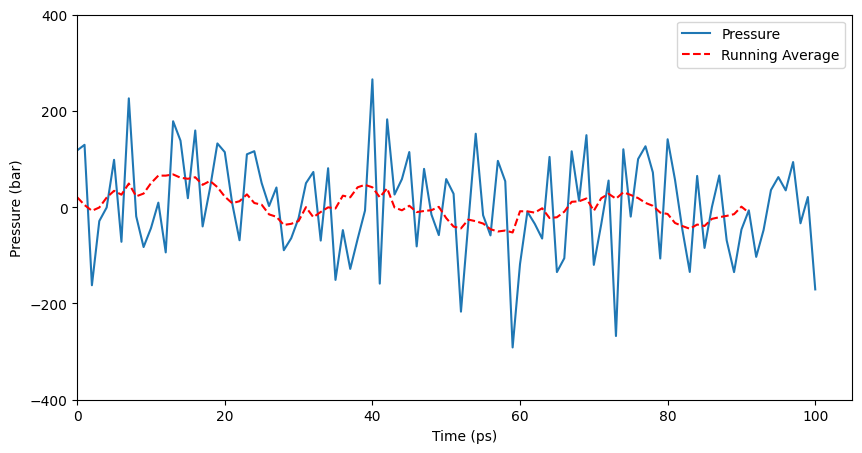

In [25]:
# Load data from the xvg file
data = np.loadtxt('pressure.xvg', comments=['#', '@'])

# Extract columns (adjust column indices as needed)
time = data[:, 0]
pressure = data[:, 1]

# Calculate running average (adjust window size as needed)
window_size = 10
running_average = np.convolve(pressure, np.ones(window_size)/window_size,
                              mode='valid')

# Plot the data and running average
fig = plt.figure(figsize=(10,5))
plt.plot(time, pressure, label='Pressure')
plt.plot(time[:len(running_average)], running_average,
         label=f'Running Average', linestyle='--', color='red')
plt.yticks(np.arange(-400.0, 450, step=200))
plt.xlabel('Time (ps)')
plt.ylabel('Pressure (bar)')
plt.legend()

# Set x-axis and y-axis limits to start from 0
plt.xlim(left=0)
# plt.ylim(bottom=-350)

plt.show()

Let's take a look at density as well, this time using energy and entering "24 0" at the prompt.

In [26]:
# !gmx energy -f npt.edr -o density.xvg

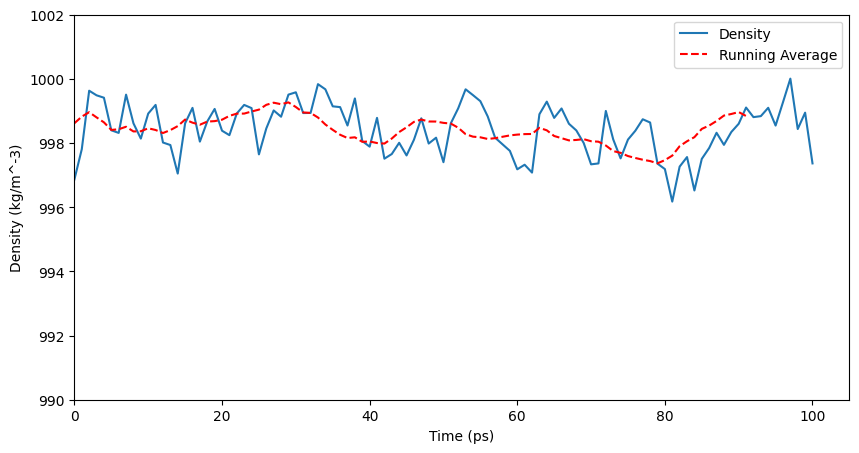

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from the xvg file
data = np.loadtxt('density.xvg', comments=['#', '@'])

# Extract columns (adjust column indices as needed)
time = data[:, 0]
density = data[:, 1]

# Calculate running average (adjust window size as needed)
window_size = 10
running_average = np.convolve(density, np.ones(window_size)/window_size,
                              mode='valid')

# Plot the data and running average
fig = plt.figure(figsize=(10,5))
plt.plot(time, density, label='Density')
plt.plot(time[:len(running_average)], running_average,
         label=f'Running Average', linestyle='--', color='red')
plt.yticks(np.arange(990.0, 1004, step=2))
plt.xlabel('Time (ps)')
plt.ylabel('Density (kg/m^-3)')
plt.legend()

# Set x-axis limits to start from 0
plt.xlim(left=0)

plt.show()

# Production Stage
Upon completion of the two equilibration phases, the system is now well-equilibrated at the desired temperature and pressure. We are now ready to release the position restraints and run production MD for data collection. The process is just like we have seen before, as we will make use of the checkpoint file (which in this case now contains preserve pressure coupling information) to grompp. We will run a 10-ns MD simulation using the md.mdp script.

In [28]:
# !gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -n index.ndx -o md_0_10.tpr

In [29]:
# Check for GPU availability

import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


In [ ]:
!export GMX_GPU_ID = torch.cuda.current_device()
!gmx mdrun -v -cpi md_0_10.cpt -deffnm md_0_10

# !gmx mdrun -v -cpi md_0_10.cpt -deffnm md_0_10 -nb gpu

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `export GMX_GPU_ID = torch.cuda.current_device()'
              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Vi

# Analysis of the results

Now that we have simulated our protein, we should run some analysis on the system. What types of data are important? This is an important question to ask before running the simulation, so you should have some ideas about the types of data you will want to collect in your own systems. For this tutorial, a few basic tools will be introduced.

The first is trjconv, which is used as a post-processing tool to strip out coordinates, correct for periodicity, or manually alter the trajectory (time units, frame frequency, etc). For this exercise, we will use trjconv to account for any periodicity in the system. The protein will diffuse through the unit cell, and may appear "broken" or may "jump" across to the other side of the box. To account for such behaviors, issue the following:

In [ ]:
# !gmx trjconv -s md_0_1.tpr -f md_0_1.xtc -o md_0_1_noPBC.xtc -pbc mol -center

Select 1 ("Protein") as the group to be centered and 0 ("System") for output. We will conduct all our analyses on this "corrected" trajectory.

**Root-Mean-Square-Deviation (RMSD)**

GROMACS has a built-in utility for RMSD calculations called rms. To use rms, issue this command:

In [ ]:
# !gmx rms -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg -tu ns

Choose 4 ("Backbone") for both the least-squares fit and the group for RMSD calculation. The -tu flag will output the results in terms of ns, even though the trajectory was written in ps. This is done for clarity of the output (especially if you have a long simulation - 1e+05 ps does not look as nice as 100 ns). The output plot will show the RMSD relative to the structure present in the minimized, equilibrated system:

If we wish to calculate RMSD relative to the crystal structure, we could issue the following:

In [ ]:
# !gmx rms -s em.tpr -f md_0_1_noPBC.xtc -o rmsd_xtal.xvg -tu ns

**Radius of Gyration (Rg)**

The radius of gyration of a protein is a measure of its compactness. If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time. Let's analyze the radius of gyration for lysozyme in our simulation:

In [ ]:
# !gmx gyrate -s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg

Choose group 1 (Protein) for analysis.

**Root-Mean-Square Fluctuation (RMSF)**


In [ ]:
# !gmx rmsf -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsf.xvg

# Further analysis

Performing a detailed analysis of molecular dynamics (MD) simulations involves several steps. Here's a general guide on how you can calculate and visualize various properties using GROMACS and generate a movie for the trajectory:

1. **Calculate RMSD (Root Mean Square Deviation):**  

`gmx rms -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg`

This will calculate the RMSD and save the data in rmsd.xvg.

2. **Calculate RMSF (Root Mean Square Fluctuation):**

`gmx rmsf -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsf.xvg`

3. **Calculate Rg (Radius of Gyration):**

`gmx gyrate -s md_0_1.tpr -f md_0_1_noPBC.xtc -o gyrate.xvg`

4. **Calculate Interaction Energy:**

`gmx energy -f md_0_1.edr -s md_0_1.tpr -o potential.xvg`

5. **Hydrogen Bond Analysis:**

`gmx hbond -s md_0_1.tpr -f md_0_1_noPBC.xtc -num hbond.xvg`

6. **Plotting Graphs:**

You can use tools like `matplotlib (in python)`, `xmgrace`, `gnuplot`, `Excel`, etc. to plot the data from the generated .xvg files.

7. **Generate a Movie:**

`gmx trjconv -s md_0_1.tpr -f md_0_1_noPBC.xtc -o trajout.xtc -pbc mol`

Then, use a visualization tool like VMD or PyMOL to create a trajectory movie:

**VMD:**

`vmd -gro md_0_1.gro -xtc trajout.xtc`

In VMD, use the "Animate" tab to create a movie.

**PyMOL:**

`pymol md_0_1.gro trajout.xtc`

In PyMOL, use the "Movie" panel to save the trajectory as a movie.

Make sure to adjust filenames and paths according to your specific setup.

Remember to check GROMACS documentation and user manuals for the most up-to-date information and options.